# Montgomery County Collision Analysis

## Introduction
<br>We will be examining traffic collisions that occurred in Montgomery County, Maryland. Our data set has over fifteen thousand collision reports based on preliminary data. The data set includes columns such as the time of day that the crash occurred, the vehicle's impact locations, and the vehicle's movement at the time of the collision. We will be using this data to see what aspects of a crash lead to lower or higher rates of injury severity. Therefore, we are most interested in the correlation of 'Injury Severity', 'Vehicle Body Type', and 'Vehicle Movement' and others. We will create new columns based on factors that are most apparent to our exploration of the data.

In [30]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import geopandas as gpd
from geopandas import GeoDataFrame


import warnings
warnings.filterwarnings('ignore')

## Data Exploration
Let us explore our data now.

In [2]:
df_county = pd.read_csv('data/Crash_Reporting_-_Drivers_Data.csv')
df_state = pd.read_csv('data/Maryland_Statewide_Vehicle_Crashes.csv')
df_nonmotor = pd.read_csv('data/Crash_Reporting_-_Non-Motorists_Data.csv')

In [3]:
county_df = df_county.copy()
non_motorist_df = df_nonmotor.copy()
df_state_data = df_state.copy()
df_county_Montgomery = df_county.copy()
county_reduced_df = county_df[['Report Number','Local Case Number','ACRS Report Type','Related Non-Motorist','Driver Substance Abuse','Non-Motorist Substance Abuse','Driver At Fault','Injury Severity','Circumstance','Driver Distracted By','Speed Limit']]
non_motorist_reduced_df = non_motorist_df[['Report Number','Local Case Number','Pedestrian Type','Pedestrian Movement','Pedestrian Actions','Pedestrian Location','Pedestrian Obeyed Traffic Signal','Pedestrian Visibility','At Fault']]
# Add columns to a new DataFrame for all visualizations

driver_distraction_df = pd.merge(county_reduced_df,non_motorist_reduced_df,on=['Report Number','Local Case Number'])
driver_distraction_df = driver_distraction_df.rename(columns={'At Fault':'Pedestrian At Fault'})

In [4]:
df_state_geo = gpd.read_file('data/Maryland_Physical_Boundaries_-_County_Boundaries_(Detailed).geojson')
df_county_Montgomery_geo = gpd.read_file('data/Maryland_Political_Boundaries_-_ZIP_Codes_-_5_Digit.geojson')

In [5]:
df_county['Crash Date/Time'] = pd.to_datetime(df_county['Crash Date/Time'])
df_county['YEAR'] = df_county['Crash Date/Time'].dt.year
df_county['MONTH'] = df_county['Crash Date/Time'].dt.month

In [6]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878343 entries, 0 to 878342
Data columns (total 55 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   YEAR                   878343 non-null  int64  
 1   QUARTER                878343 non-null  object 
 2   LIGHT_DESC             841025 non-null  object 
 3   LIGHT_CODE             878343 non-null  float64
 4   COUNTY_DESC            878329 non-null  object 
 5   COUNTY_NO              878329 non-null  float64
 6   MUNI_DESC              0 non-null       float64
 7   MUNI_CODE              659957 non-null  float64
 8   JUNCTION_DESC          760119 non-null  object 
 9   JUNCTION_CODE          791512 non-null  float64
 10  COLLISION_TYPE_DESC    878343 non-null  object 
 11  COLLISION_TYPE_CODE    878343 non-null  int64  
 12  SURF_COND_DESC         789107 non-null  object 
 13  SURF_COND_CODE         791512 non-null  float64
 14  LANE_CODE              668083 non-nu

## Data Cleaning
<br>
Let us now drop columns that are missing more than 80% of values on average

In [7]:
df_county.drop(columns=df_county.columns[df_county.isna().mean() >= .8], inplace=True)

In [8]:
# Merge the two dataframes with the values that do not already exist in the county data
df_county = pd.merge(left=df_county, right=df_nonmotor[~df_nonmotor['Report Number'].isin(
    df_county['Report Number'])], on='Report Number', how='left')

Let us overwrite the state DataFrame with only the columns that we would like to analyze.

In [9]:
df_state = df_state[[  'YEAR', 'LIGHT_DESC', 'COUNTY_DESC',
                       'COLLISION_TYPE_DESC', 'WEATHER_DESC',
                       'REPORT_NO', 'WEATHER_CODE', 'ACC_DATE',
                       'LATITUDE', 'LONGITUDE', 'LOCATION']]
df_state.isna().sum()

YEAR                        0
LIGHT_DESC              37318
COUNTY_DESC                14
COLLISION_TYPE_DESC         0
WEATHER_DESC           427866
REPORT_NO                   0
WEATHER_CODE                0
ACC_DATE                    0
LATITUDE                    0
LONGITUDE                   0
LOCATION                    0
dtype: int64

### Clean the "df_state_data" for a choropleth

In [10]:
# Clean the data frames
# Take the location lat and long of montgomery county
map_df_montgomery = df_county_Montgomery.loc[:,('Latitude','Longitude','Location')]

# Take the location lon and lat of all counties in Maryland. other data types to think about ROUTE_TYPE_CODE, Look for more in .info
map_df_counties = df_state_data.loc[:,('YEAR','COUNTY_DESC','LATITUDE','LONGITUDE','LOCATION')]
# group by counties and count how many accidents per
county_count = map_df_counties.groupby(['COUNTY_DESC']).count()
county_count = county_count.reset_index()
county_count = county_count[['COUNTY_DESC','YEAR']]
#Create merged data frame with the total count of 

merged_df = GeoDataFrame(pd.merge(df_state_geo,county_count,left_on=df_state_geo.COUNTY, right_on=county_count.COUNTY_DESC,how='outer')).drop(['key_0','COUNTY_DESC'], axis=1)
# merged_df = merged_df.rename(columns={'YEAR' : 'COUNT'})

**Below cell takes a few minutes to run.**

In [11]:
# List of zip codes only in Montgomery county (Collected from the counties website)(https://planning.maryland.gov/MSDC/Documents/zipcode_map/2010/montzc10.pdf)
list_of_montgomery_zip_codes = ['20707','20777','20812','20814','20815','20816','20817','20818','20833','20837','20838','20839','20841','20842','20850','20851','20852','20853','20854','20855','20860','20861','20862','20866','20868','20871','20872','20874','20876','20877','20878','20879','20882','20886','20889','20892','20894','20895','20899','20901','20902','20903','20904','20905','20906','20910','20912','21771','21797']
# Drop all data that does not have a zipcode within Montgomery county
df_county_Montgomery_geo_test = df_county_Montgomery_geo.set_index(keys = 'ZIPCODE1')

df_county_Just_Montgomery_geo = df_county_Montgomery_geo_test.loc[list_of_montgomery_zip_codes]
df_county_Just_Montgomery_geo = df_county_Just_Montgomery_geo.reset_index()
# clean the data frames for the lon an lat
# Take the location lat and long of montgomery county
map_df_montgomery = df_county_Montgomery.loc[:,['Latitude','Longitude','Location']]
# Read the data.

# Create a new GeoDataFrame using Lat and Lon points
geometry_montgomery = map_df_montgomery
geometry_montgomery['geometry'] = gpd.points_from_xy(map_df_montgomery.Longitude, map_df_montgomery.Latitude, crs="EPSG:4326")
points = gpd.GeoDataFrame(geometry_montgomery)
points_set = points.set_geometry("geometry")
## WARNING THIS TAKES ~20mins

# Check the accident points against the ZIP code polygons
poly_count_by_zip = []

for i, polygon in df_county_Just_Montgomery_geo.iterrows():
    Current_poly_count = 0
    for j, point in points_set.iterrows():
        if polygon.geometry.contains(point.geometry):
            Current_poly_count = Current_poly_count + 1
    poly_count_by_zip.append(Current_poly_count)
    
#Create a data frame to match the 'OBJECTID' and count of accidents
df_count_by_zip_zone = pd.DataFrame({
    "OBJECTID" : df_county_Just_Montgomery_geo['OBJECTID'],
    "Count of accidents" : poly_count_by_zip  
})
#Create merged data frame with the total count of accidents for each zip code and the "df_county_Just_Montgomery_geo" df
merged_df_zips = GeoDataFrame(pd.merge(df_county_Just_Montgomery_geo,df_count_by_zip_zone,on = 'OBJECTID',how='outer'))

In [12]:
# Fill NA values with the median value
df_state['LIGHT_DESC'] = df_state['LIGHT_DESC'].fillna(df_state['LIGHT_DESC'].value_counts().index[0])
df_state['COUNTY_DESC'] = df_state['COUNTY_DESC'].fillna('NA')

In [13]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878343 entries, 0 to 878342
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 878343 non-null  int64  
 1   LIGHT_DESC           878343 non-null  object 
 2   COUNTY_DESC          878343 non-null  object 
 3   COLLISION_TYPE_DESC  878343 non-null  object 
 4   WEATHER_DESC         450477 non-null  object 
 5   REPORT_NO            878343 non-null  object 
 6   WEATHER_CODE         878343 non-null  float64
 7   ACC_DATE             878343 non-null  int64  
 8   LATITUDE             878343 non-null  float64
 9   LONGITUDE            878343 non-null  float64
 10  LOCATION             878343 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 73.7+ MB


Let us clean the Vehicle Body Type column so that the categories are more apparent.

In [14]:
df_county['Simple Vehicle Body Type'] = df_county['Vehicle Body Type'].replace({'TRANSIT BUS':"BUS", "SCHOOL BUS": "BUS", "(SPORT) UTILITY VEHICLE": "SUV", "OTHER LIGHT TRUCKS (10,000LBS (4,536KG) OR LESS)": "LIGHT SEMITRUCKS", "CARGO VAN/LIGHT TRUCK 2 AXLES (OVER 10,000LBS (4,536 KG))": "MEDIUM SEMITRUCKS", "POLICE VEHICLE/NON EMERGENCY": "POLICE", "POLICE VEHICLE/EMERGENCY":"POLICE", "MEDIUM/HEAVY TRUCKS 3 AXLES (OVER 10,000LBS (4,536KG))":"HEAVY SEMITRUCK", "STATION WAGON":"SUV", "TRUCK TRACTOR":"TRACTOR", "AMBULANCE/EMERGENCY":"FIRST RESPONDER", "FIRE VEHICLE/EMERGENCY":"FIRST RESPONDER","OTHER BUS":"BUS","FIRE VEHICLE/NON EMERGENCY":"FIRST RESPONDER", "RECREATIONAL VEHICLE":"RV", "AMBULANCE/NON EMERGENCY":'FIRST RESPONDER', 'ALL TERRAIN VEHICLE (ATV)':"ATV"})
# df_county['Simple Vehicle Body Type'] = df_county['Simple Vehicle Body Type'].drop(axis='columns', ['MOPED', 'AUTOCYCLE', 'LOW SPEED VEHICLE', 'CROSS COUNTRY BUS', 'FARM VEHICLE', 'LIMOUSINE'])
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'MOPED']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'AUTOCYCLE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'LOW SPEED VEHICLE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'CROSS COUNTRY BUS']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'FARM VEHICLE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'LIMOUSINE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'UNKNOWN']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'OTHER']

In [15]:
df_county['Numeric Severity'] = df_county['Injury Severity_x'].replace({'NO APPARENT INJURY': 0, 'POSSIBLE INJURY': 1, 'SUSPECTED MINOR INJURY': 2, 'SUSPECTED SERIOUS INJURY':3, 'FATAL INJURY':4})

In [16]:
#Merges unwanted data in Weather Column
df_county['Weather_x'] = df_county['Weather_x'].replace(
    {"BLOWING SAND, SOIL, DIRT": "SEVERE WINDS", 
     "WINTRY MIX": "OTHER" , "BLOWING SNOW": "SNOW"})#, "UNKNOWN": "OTHER"})

#Merges unwanted data in Weather Column of State Data
df_state['WEATHER_DESC'] = df_state['WEATHER_DESC'].dropna(how='any')
df_state['WEATHER_DESC'] = df_state['WEATHER_DESC'].replace(
    {"Blowing Sand, Soil, Dirt": "SEVERE WINDS", 
     "Wintry Mix": "Other" , "Blowing Snow": "SNOW"})#, "Unknown": "Other"})
df_county.info()

## Data Visualization

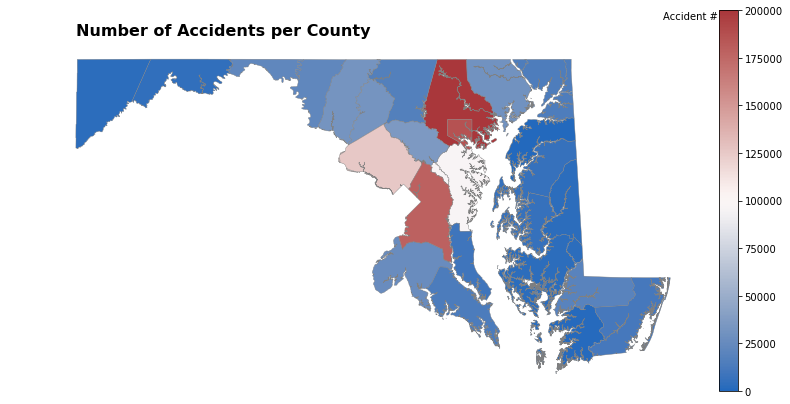

In [17]:
# List of different color pallets to use within plt
# run "plt.colormaps()"

# plot a cloropleth with a heatbar for number of crashes per county.

# plot figure (cmap = the color map)
f, ax = plt.subplots(1, figsize=(15, 7))
ax = merged_df.plot(column='YEAR', cmap='vlag' ,ax=ax, linewidth=0.4, edgecolor=".5")

# Set the axes of the plot to zoom and turn off the to make cleaner
ax.set_xlim([-80, -75])
ax.set_ylim([37.8, 40])
ax.axis("off")

#Create a heatbar and set cmap to match the figure 
bar_info = plt.cm.ScalarMappable(cmap="vlag", norm=plt.Normalize(vmin=0, vmax=200000))
cbar = f.colorbar(bar_info)

# Text for "Accident number"
cbar.ax.text(.98, 0.98, 'Accident #',transform=ax.transAxes)
# Text for "Number of Accidents per County"
ax.text(0.103, 0.97, 'Number of Accidents per County', transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')

#Save the plot as a png
plt.savefig('images/Accidents_per_county.png',bbox_inches='tight',dpi=300)

The above plot shows the State of Maryland collision by county. We can see that there are 3 countys that have the highest accident rates, and the rest of the counties have roughly 1/3 of the top 3 highest accident rates in all of Maryland.

In [18]:
# plot a cloropleth with a heatbar for number of crashes per ZIP code in Montgomery County.

f, ax = plt.subplots(1, figsize=(15, 7))
ax = merged_df_zips.plot(column='Count of accidents', cmap='vlag',ax=ax, linewidth=0.4, edgecolor=".5")
ax.set_xlim([-77.6, -76.8])
ax.set_ylim([38.9, 39.55])
ax.axis("off")

# Text for "Accident number" (Note: had to change the )
ax.text(.95, 0.98, 'Accident #',transform=ax.transAxes)
# Text for "Number of Accidents per County"
ax.text(0, 1, 'Number of Accidents by ZIP code in Montgomery County', transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')

#Create a heatbar and set cmap to match the figure 
bar_info = plt.cm.ScalarMappable(cmap="vlag", norm=plt.Normalize(vmin=0, vmax=11000))
cbar = f.colorbar(bar_info)

plt.savefig('images/Accidents_per_zip.png',bbox_inches='tight',dpi=300)

The Montgomery county accident rate shown emphasizes that the most dense areas have the most collisions.

In [19]:
# Bar Graph to count driver distractions

sns.catplot(data=driver_distraction_df,y='Driver Distracted By',hue='ACRS Report Type',kind='count',aspect=60/25)
plt.grid()
plt.title("ACRS Report Type by Driver Distractions");
plt.savefig("images/Driver_Distractions.png")

---

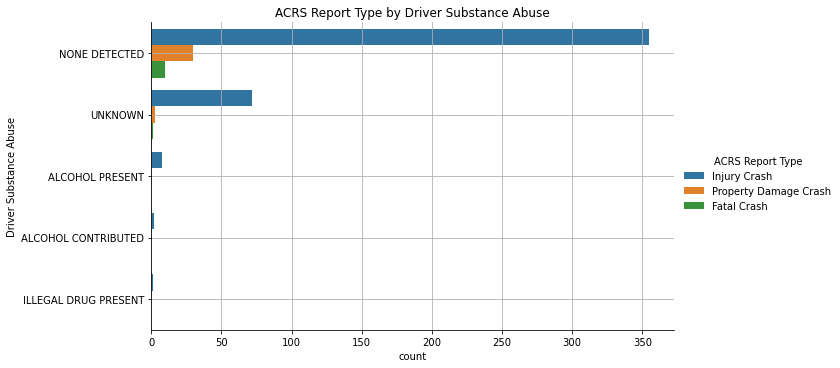

In [20]:
# Graph to viewsubstance abuse with ACRS report type

sns.catplot(data=driver_distraction_df,y='Driver Substance Abuse',hue='ACRS Report Type',kind='count',aspect=30/15)
plt.grid()
plt.title("ACRS Report Type by Driver Substance Abuse");
plt.savefig("images/Driver_Substance_Abuse.png")

---

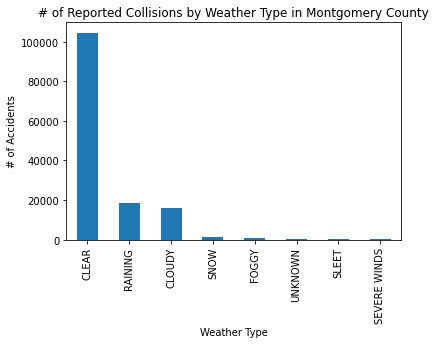

In [21]:
#Graph1: Raw Counts of Reported Accidents by Weather Type
df_county_weather = df_county[df_county['Weather_x'].notna()]
df_county_weather = df_county_weather[ df_county_weather['Weather_x'] !='OTHER']
weatherGroups = df_county_weather.groupby("Weather_x")
weather_Reports = weatherGroups['Report Number'].count().sort_values(ascending=False)

chart1 = weather_Reports.plot(kind="bar", title="Accidents by Weather Type")
chart1.set_xlabel("Weather Type")
chart1.set_ylabel("# of Accidents")
chart1.set_title("# of Reported Collisions by Weather Type in Montgomery County");
plt.savefig("images/AccidentsByWeatherCounty.png")

We see that most accidents in Montgomery County occured when the weather was clear, following with raining conditions and cloudy. This makes sense since most of the days are clear. In raining conditions we see the 2nd most occuring accidents for reasons like slippery roads and less traction along with impared visability. The 3rd most common condition is cloudy, being that visibility is diminished in this weather. In Montgomery, snow reaches on average 18-inches according to msa.maryland.gov, that data certainly not as apparent to what we hypothesised. In order to visualize Foggy, Severse Winds, and Sleet, we shall perform log base 10 transformation. Let us do so now.

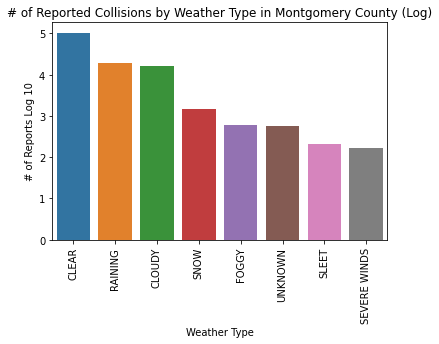

In [22]:
#Log Version of graph1
x1 = df_county_weather['Weather_x'].value_counts().index
y1 = np.log10(df_county_weather['Weather_x'].value_counts().values)
chart = sns.barplot(x=x1,y=y1)
plt.xticks(rotation=90)
plt.xlabel("Weather Type")
plt.ylabel("# of Reports Log 10")
plt.title("# of Reported Collisions by Weather Type in Montgomery County (Log)");
plt.savefig("images/log10AccidentsByWeatherCounty.png")

Above we performed log base 10 transformation to better visualize the minimal categorical counts. We see now that indeed Sleet weather conditions are the least common as opposed to Foggy conditions.
<br><br>
Let us now visualize the same categories with our state data.

In [23]:
#Graph 2: Raw Counts of Reported Accidents by Weather Type (State Data)
df_state_weather = df_state[df_state['WEATHER_DESC'].notna()]
# remove the following labels from df_state_weather
df_state_weather = df_state_weather[df_state_weather['WEATHER_DESC'] != "Not Applicable"]
df_state_weather = df_state_weather[df_state_weather['WEATHER_DESC'] != "Other"]
stateWeather = df_state_weather.groupby("WEATHER_DESC")
stateWeather_Reports = stateWeather['REPORT_NO'].count().sort_values(ascending=False)

chart1 = stateWeather_Reports.plot(kind="bar", title="Accidents by Weather Type")
chart1.set_xlabel("Weather Type")
chart1.set_ylabel("# of Accidents")
chart1.set_title("# of Reported Collisions by Weather Type in Maryland");
plt.savefig("images/AccidentsByWeatherState.png")

We see that most accidents in the State of Maryland occured when the weather was clear, following with raining conditions and cloudy. This makes sense since we have just seen that our county data set showed very similar results, differing in that snow conditions were more apparent. However, in our State DataFrame we see that is not the case, accidents with foggy conditions occur more often than snow related accidents. Severe winds and sleet are also flipped in our state data. 
<br><br>
Let us now perform log base 10 on our state weather categories to better visualize them.

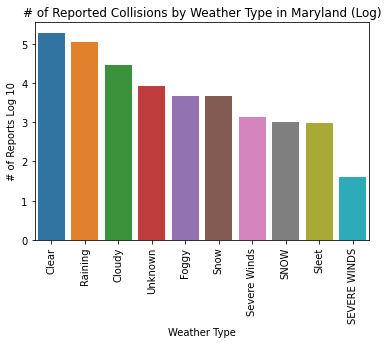

In [24]:
#Log Version of Graph 2
x2 = df_state_weather['WEATHER_DESC'].value_counts().index
y2 = np.log10(df_state_weather['WEATHER_DESC'].value_counts().values)
chart = sns.barplot(x=x2,y=y2)
plt.xticks(rotation=90)
plt.xlabel("Weather Type")
plt.ylabel("# of Reports Log 10")
plt.title("# of Reported Collisions by Weather Type in Maryland (Log)");
plt.savefig("images/log10AccidentsByWeatherState.png")

Let us now ask, What is the chance of injury given vehicle body type?

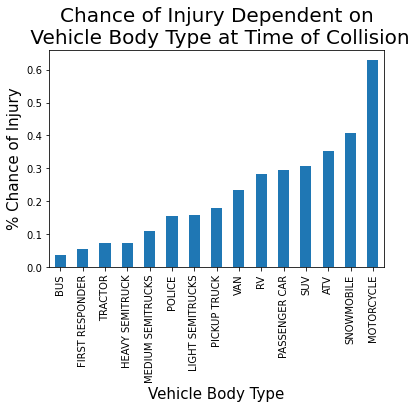

In [25]:
first_x_vals = df_county.groupby('Simple Vehicle Body Type')['Numeric Severity'].mean().sort_values()[:-1]
last_x_vals =  pd.Series(df_county.groupby('Simple Vehicle Body Type')['Numeric Severity'].mean().sort_values()[-1]-1).rename({0:"MOTORCYCLE"})
last_x_vals.name = "Numeric Severity"
first_x_vals.append(last_x_vals).plot.bar()
plt.title('Chance of Injury Dependent on\n Vehicle Body Type at Time of Collision', size=20)
plt.ylabel('% Chance of Injury', size = 15)
plt.xlabel("Vehicle Body Type", size = 15);
plt.savefig("images/ChanceOfInjuryDependentOnVehicleBodyType.png")

As we see above, motorcycles are the most prone to injury with roughly 60% chance of injury when involved in an accident. We then have recreational vehicles like Snowmobiles and ATVs taking 2nd and 3rd place respectively. Following SUV and Passenger cars almost tied with chance of injury in a collision. It is intresting to see that Bus's are the least prone to injuries which is a good thing being that these vehicles are typically transproting young children to and from schools.
<br><br>
Let us now visualize our following question. What is the chance of injury dependent on impact location at time of collision?

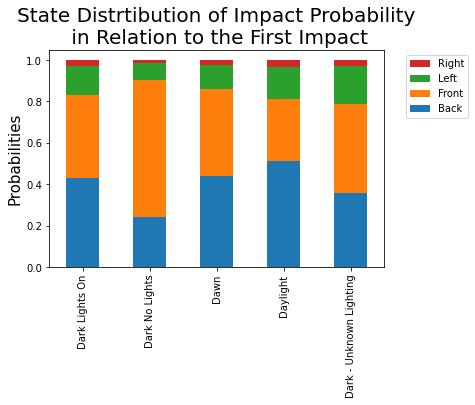

In [26]:
df_state['First Impact Simple'] = df_state['COLLISION_TYPE_DESC'].replace({"Same Direction Rear End":"Back", "Single Vehicle":"Front", "Same Movement Angle":"Back", "Same Direction Sideswipe":"Left", "Head On Left Turn":"Front", "Head On":"Front", "Same Direction Right Turn":"Right", "Same Direction Left Turn":"Left", "Opposite Direction Sideswipe":"Left", "Same Direction Rear End Left Turn":"Back", "Angle Meets Left Turn":"Left", "Same Direction Rear End Right Turn":"Back", "Same Direction Both Left Turn":"Left", "Angle Meets Right Turn":"Right", "Angle Meets Left Turn Head On":"Front", "Opposite Direction Both Left Turn":"Left"})
df_state = df_state[df_state['First Impact Simple'] != "Unknown"]
df_state = df_state[df_state['First Impact Simple'] != "Not Applicable"]
df_state = df_state[df_state['First Impact Simple'] != "Other"]

movementImpact = pd.crosstab(df_state['LIGHT_DESC'], df_state['First Impact Simple'])
movementImpact = movementImpact.div(df_state['LIGHT_DESC'].value_counts(), axis=0)
# reorder from least to most severe
movementImpact.iloc[[1,2,3,4,0]].plot.bar(stacked=True)
plt.title('State Distrtibution of Impact Probability\n in Relation to the First Impact', size=20)
plt.xticks(rotation = 90)
plt.ylabel('Probabilities', size=15)
current_handles, curr_labels = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)
reverse_labels = reversed(curr_labels)
plt.legend(reversed_handles, reverse_labels, bbox_to_anchor=(1.05, 1.0), loc='upper left');
plt.savefig("images/StateDistOfImpactProb.png")

From the above state data, we see that an impact from the right side of the vehicle is very minimal in terms of probability if ever in a collision. collisions that occur from the left of the vehicle are most apparent in Dark settings. A head on collision is has the highest probabilities throughout the categories of lighting descriptions for all state accidents. It is intresting to see that being hit from the back of the vehicle is most common in daylight settings, possibly because drivers have more distractions and take for granted the good weather conditions when driving causing them to look away even for a second. It is also intresting to see that the probability of being hit head-on is more apparent than rear-end when there is no lights on a dark night.
<br><br>
What is the Montgomery County Distrtibution of Impact Probability in Relation to the First Impact location?

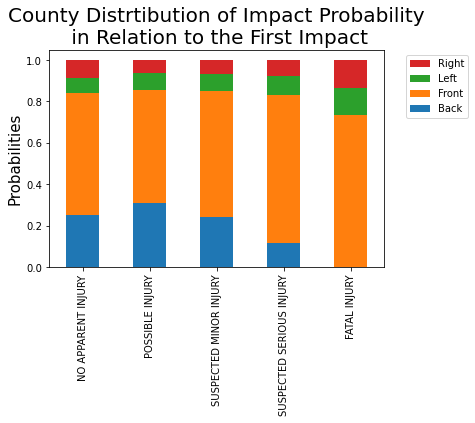

In [27]:
# Replace to simple impact locations
df_county['First Impact Simple'] = df_county['Vehicle First Impact Location'].replace({'ELEVEN OCLOCK': "Front", 'TWELVE OCLOCK': "Front", 'ONE OCLOCK': "Front", 'TWO OCLOCK': "Right", 'THREE OCLOCK': "Right", 'FOUR OCLOCK': "Right", 'FIVE OCLOCK': "Back", 'SIX OCLOCK': "Back", 'SEVEN OCLOCK': "Back", 'EIGHT OCLOCK': "Left", 'NINE OCLOCK': "Left", 'TEN OCLOCK': "Left", 'ROOF TOP': "Top", 'UNDERSIDE': "Bottom", 'NON-COLLISION': "No Collision",'UNKNOWK': "Unknown"})
# We will drop these values because they are unusual to compare with collisions 
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'UNKNOWN'], inplace=True)
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'Top'], inplace=True)
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'Bottom'], inplace=True)
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'No Collision'], inplace = True)
# Create cross tab chart 
movementImpact = pd.crosstab(df_county['Injury Severity_x'], df_county['First Impact Simple'])
movementImpact = movementImpact.div(df_county['Injury Severity_x'].value_counts(), axis=0)
# reorder from least to most severe
movementImpact.iloc[[1,2,3,4,0]].plot.bar(stacked=True)
plt.title('County Distrtibution of Impact Probability\n in Relation to the First Impact', size=20)
plt.xticks(rotation = 90)
plt.ylabel('Probabilities', size=15)
current_handles, curr_labels = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)
reverse_labels = reversed(curr_labels)
plt.legend(reversed_handles, reverse_labels, bbox_to_anchor=(1.05, 1.0), loc='upper left');
plt.savefig("images/CountyDistOfImpactProb.png")

Above we see the Montgomery county data showing that no fatal injuries occur from a rear-end collision but instead were predominantly from head-on collisions roughly 80% of all accidents showed this to be true. The category Possible injuries had the highest probability of being caused from rear-ended accidents.

In [28]:
ct_table = pd.crosstab(df_county['Weather_x'], df_county['Injury Severity_x'])
print("contingency table :\n",ct_table)

contingency table :
 Injury Severity_x  FATAL INJURY  NO APPARENT INJURY  POSSIBLE INJURY  \
Weather_x                                                              
CLEAR                       107               83590            10478   
CLOUDY                       12               12407             1798   
FOGGY                         0                 491               64   
OTHER                         1                 574               66   
RAINING                       6               14834             2004   
SEVERE WINDS                  0                 127               18   
SLEET                         0                 169               18   
SNOW                          0                1214              126   
UNKNOWN                       0                 394               11   

Injury Severity_x  SUSPECTED MINOR INJURY  SUSPECTED SERIOUS INJURY  
Weather_x                                                            
CLEAR                                7252     

In [33]:
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table)
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:\n",expected)

chi2 statistic:     129.35
p-value:            1.1705e-13
degrees of freedom: 32
expected frequencies:
 [[9.22879423e+01 8.33521256e+04 1.06812307e+04 7.32590475e+03
  8.36451032e+02]
 [1.39413546e+01 1.25914774e+04 1.61354583e+03 1.10667801e+03
  1.26357357e+02]
 [5.46755172e-01 4.93815385e+02 6.32804021e+01 4.34019463e+01
  4.95551116e+00]
 [6.36076561e-01 5.74488196e+02 7.36182896e+01 5.04923632e+01
  5.76507486e+00]
 [1.65722756e+01 1.49676584e+04 1.91804361e+03 1.31552302e+03
  1.50202688e+02]
 [1.41651092e-01 1.27935669e+02 1.63944276e+01 1.12443986e+01
  1.28385355e+00]
 [1.84056196e-01 1.66234882e+02 2.13023136e+01 1.46105562e+01
  1.66819188e+00]
 [1.31636270e+00 1.18890536e+03 1.52353311e+02 1.04494125e+02
  1.19308429e+01]
 [3.73525810e-01 3.37359026e+02 4.32311658e+01 2.96508346e+01
  3.38544822e+00]]


## Conclusion

...